# CoP3E model selection and training

### Import  packages

In [1]:
#packages
from modules.train_model import TrainModel
from modules.train_model import *
from modules.feature_calculator import FeatureCalculator
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import numpy as np

### Project specific tools

In [5]:
#class
tm = TrainModel() 
fc = FeatureCalculator()

In [7]:
ensembl_pseudogene = pickle.load(open('data/ensembl_pseudogene.pkl', 'rb'))
datasets = pickle.load(open('data/datasets.pkl', 'rb'))
frqs_dict = pickle.load(open('data/frqs_dict.pkl', 'rb'))
selected_features = pickle.load(open('data/selected_features.pkl', 'rb'))

In [4]:
X = fc.get_frqs_table(frqs_dict, datasets, selected_features)
y = tm.get_targets(datasets)
X_unk = fc.get_unk_frqs_table(frqs_dict, selected_features)

In [5]:
rng = np.random.default_rng(1)
indices = rng.permutation(len(y))
X, y = X[indices], y[indices]

### Hyperparameter tuning

In [6]:
#lr = LogisticRegression(max_iter=6000)
#best_params = tm.hyperparameter_tuning(lr, X, y, tm.lr_param_grid, scoring='f1', cv=10)

In [7]:
#lr = best_params
#pickle.dump(lr, open('lr.pkl', 'wb'))
#lr = pickle.load(open('lr.pkl', 'rb'))

In [8]:
lr = LogisticRegression(C=100, max_iter=6000)

In [9]:
lr_bin_preds, lr_preds = tm.train(lr, X, y, 0.4)
tm.evaluate(y, lr_bin_preds)

{'accuracy': 0.8669741042923023,
 'precision': 0.7394916911045943,
 'recall': 0.8745664739884393,
 'specificity': 0.8636131013306039,
 'f1': 0.8013771186440678}

In [10]:
#svm = SVC(max_iter=-1)
#best_params = tm.hyperparameter_tuning(svm, X, y, tm.svm_param_grid, scoring='f1', cv=10)

In [11]:
#svm = best_params
#pickle.dump(svm, open('svm.pkl', 'wb'))
#svm = pickle.load(open('svm.pkl', 'rb'))

In [12]:
svm = SVC(C=100, degree=2, kernel='poly',probability=True)

In [13]:
svm_bin_preds, svm_preds = tm.train(svm, X, y, 0.4)
tm.evaluate(y, svm_bin_preds)

{'accuracy': 0.8813409010287336,
 'precision': 0.7688798783578307,
 'recall': 0.876878612716763,
 'specificity': 0.8833162743091095,
 'f1': 0.8193356737780177}

### ensemble model

In [14]:
mlp = MLPClassifier((100,50), learning_rate='adaptive')

In [15]:
ensemble = tm.get_stacking(lr, svm, mlp)

In [16]:
ensemble_bin_preds, ensemble_preds = tm.train(ensemble, X, y, 0.3)
tm.evaluate(y, ensemble_bin_preds)

{'accuracy': 0.8824051081943952,
 'precision': 0.7698533131006575,
 'recall': 0.8797687861271676,
 'specificity': 0.8835721596724667,
 'f1': 0.8211491772322632}

In [17]:
tm.optimize_thresh(y, ensemble_preds)

0.295

In [18]:
pickle.dump(ensemble, open('data/CoP3E.pkl', 'wb'))
pickle.dump(ensemble_preds, open('data/ensemble_preds.pkl', 'wb'))
pickle.dump(ensemble_bin_preds, open('data/ensemble_bin_preds.pkl', 'wb'))

CoP3E = pickle.load(open('data/CoP3E.pkl', 'rb'))
ensemble_preds = pickle.load(open('data/ensemble_preds.pkl', 'rb'))
ensemble_bin_preds = pickle.load(open('data/ensemble_bin_preds.pkl', 'rb'))

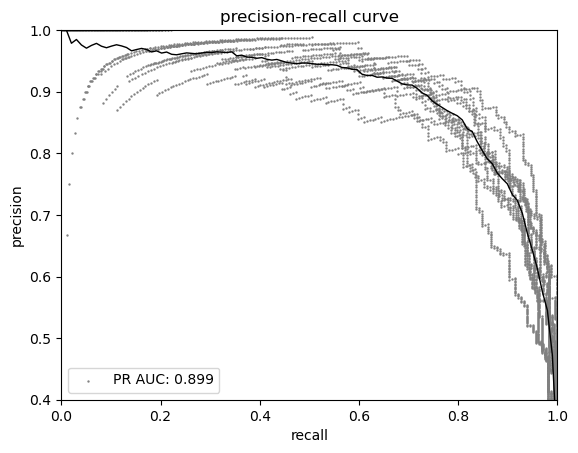

In [19]:
fig = tm.pr_curve(y, ensemble_preds)
fig.savefig('figures/PR_curve.svg')

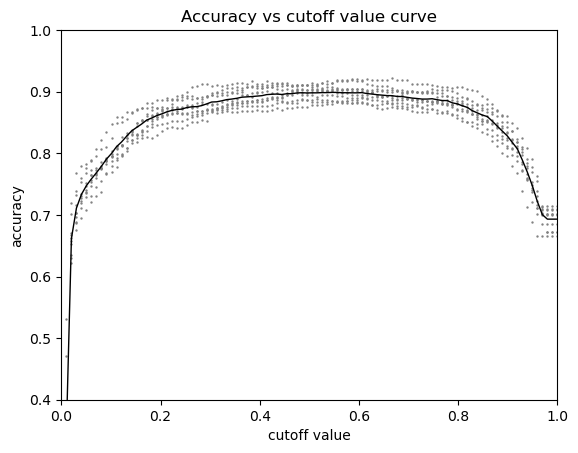

In [20]:
fig = tm.accuracy_vs_cutoff_value(y, ensemble_preds)
fig.savefig('figures/accuracy_vs_cutoff.svg')

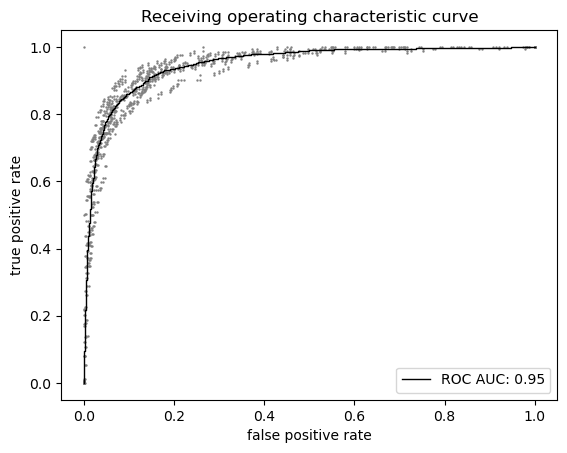

In [21]:
fig = tm.roc_curve(y, ensemble_preds)
fig.savefig('figures/ROC_curve.svg')

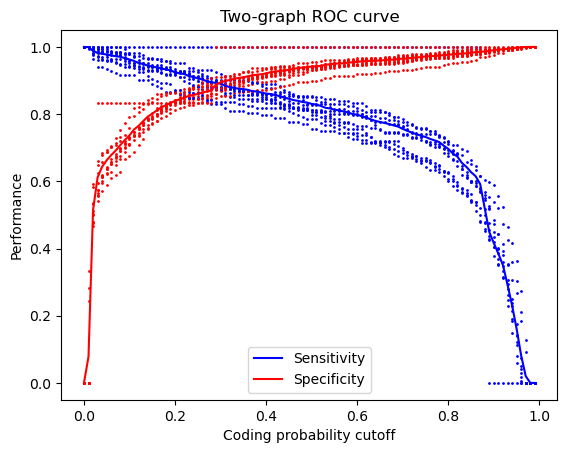

In [22]:
fig = tm.two_graph_roc_curve(y, ensemble_preds)
fig.savefig('figures/sensitivity_and_sensitivity_ROC.svg')

In [23]:
#predictions on pseudogene transcripts lacking evidence of translation
predictions = tm.CoP3E_predict(ensembl_pseudogene, X_unk, CoP3E)

### SHAP values 

In [24]:
# # Calculate SHAP values on all X dataset
# X_shap, shap_values = tm.get_shap_values(ensemble, X, bg_size=100, n_instances=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
# # Save shap values et X_dataset used for shap values calculation
# with open('data/SHAP_values.pkl', 'wb') as f:
#     pickle.dump(shap_values, f)
# with open('data/X_shap.pkl', 'wb') as f:
#     pickle.dump(X_shap, f)

In [2]:
with open('data/SHAP_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)
with open('data/X_shap.pkl', 'rb') as f:
    X_shap = pickle.load(f)

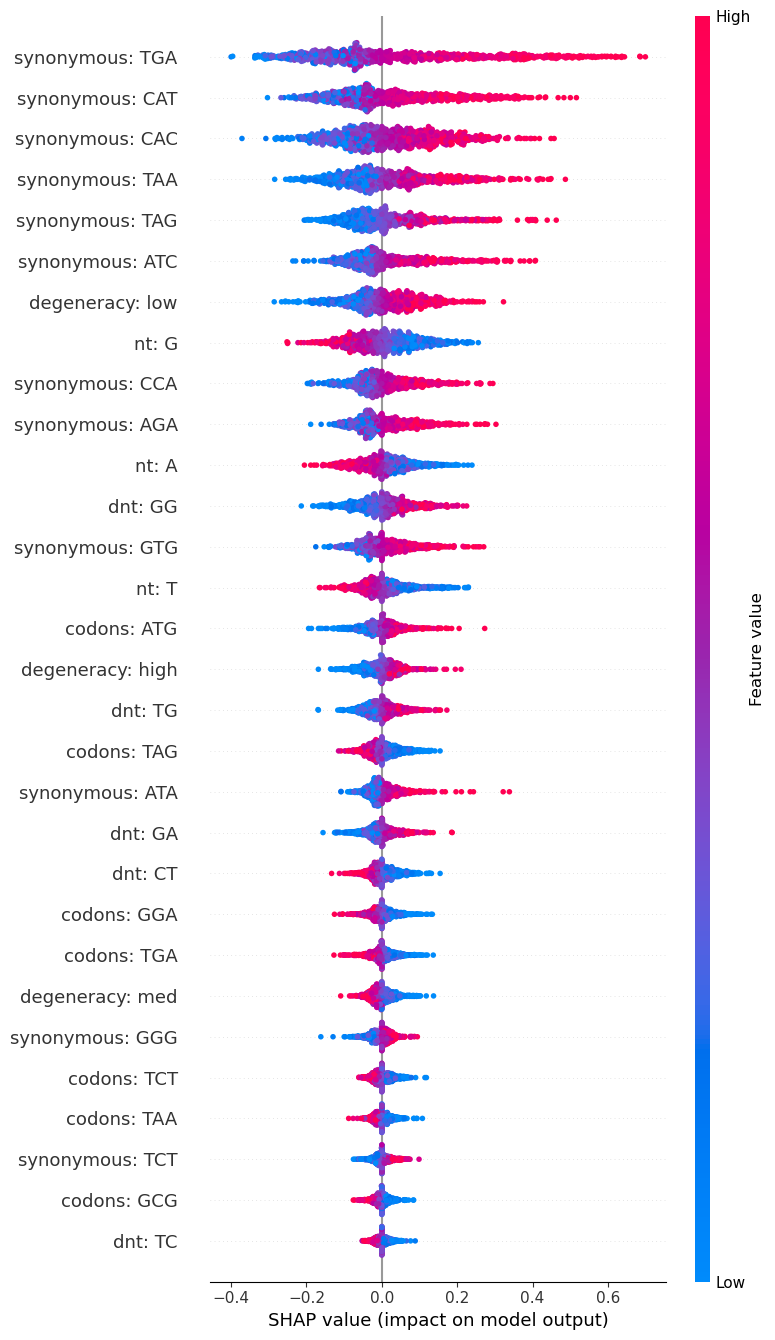

In [8]:
fig = tm.plot_SHAP(shap_values, X_shap, selected_features, n_features=30)
fig.savefig('figures/SHAP_values.svg')